<a href="https://colab.research.google.com/github/its-Nhi-Ho/DS102__P.21/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 1 (4 scores): Implement PCA using Numpy.**

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import random
import imageio.v3 as iio
import cv2
from google.colab import drive
from collections import Counter

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Hàm load ảnh từ tất cả người
def load_all_images(base_path, img_size=(64, 80)):
    all_images = []
    all_labels = []
    all_filenames = []

    person_folders = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    person_to_label = {person: idx for idx, person in enumerate(person_folders)}

    label_counts = {}

    for person_folder in person_folders:
        person_path = os.path.join(base_path, person_folder)
        images = []
        filenames = []

        for filename in os.listdir(person_path):
            img_path = os.path.join(person_path, filename)
            try:
                img = imread(img_path)
                if img.ndim == 3:
                    img = img.mean(axis=2)
                if img.max() > 1 or img.min() < 0:
                    img = (img - img.min()) / (img.max() - img.min())
                img = resize(img, img_size, anti_aliasing=True)
                if img.max() > 1 or img.min() < 0:
                    img = (img - img.min()) / (img.max() - img.min())
                images.append(img)
                filenames.append(filename)
            except Exception as e:
                print(f"Lỗi đọc ảnh {img_path}: {e}")

        if images:
            all_images.extend(images)
            label = person_to_label[person_folder]
            all_labels.extend([label] * len(images))
            all_filenames.extend(filenames)
            label_counts[label] = len(images)

    print("Số lượng ảnh mỗi người:")
    for label, count in label_counts.items():
        person = person_folders[label]
        print(f"Nhãn {label} ({person}): {count} ảnh")

    return np.array(all_images), np.array(all_labels), all_filenames, person_folders

In [53]:
# Lớp PCA
class Principle_Component_Analysis:
    def __init__(self, d_principle: int = 1):
        self.d_principle = d_principle

    def fit(self, X: np.ndarray):
        if np.any(np.isinf(X)) or np.any(np.isnan(X)):
            raise ValueError("Dữ liệu đầu vào chứa inf hoặc NaN.")

        n_samples = X.shape[0]
        if n_samples <= 1:
            raise ValueError("Số lượng mẫu phải lớn hơn 1 để tính PCA.")

        self.mean_ = np.mean(X, axis=0, keepdims=True)
        X_centered = X - self.mean_
        cov = (X_centered.T @ X_centered) / (n_samples - 1)

        if np.any(np.isinf(cov)) or np.any(np.isnan(cov)):
            raise ValueError("Ma trận covariance chứa inf hoặc NaN.")

        eigenvalues, eigenvectors = np.linalg.eig(cov)
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]
        eigenvectors = eigenvectors.T

        eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i, :]) for i in range(eigenvectors.shape[0])]
        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)

        eigenvalues = np.array([value for (value, _) in eigen_pairs])
        eigenvectors = np.array([vector for (_, vector) in eigen_pairs])

        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)

        self.principle_values = eigenvalues[:self.d_principle]
        self._W = eigenvectors[:self.d_principle]

        self.explained_variance_ratio_ = self.principle_values / np.sum(eigenvalues)

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        X_centered = X - self.mean_
        X_hat = X_centered @ self._W.T
        return X_hat

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [54]:
# Hàm hiển thị ảnh
def display_images(images=None, titles=None, base_path=None, person_path=None, img_size=(65, 80), num_images_to_display=10):
    plt.figure(figsize=(10, 5))

    if base_path and person_path:
        full_path = os.path.join(base_path, person_path)
        filenames = os.listdir(full_path)

        for i, filename in enumerate(filenames):
            if i >= num_images_to_display:
                break
            try:
                image = imread(os.path.join(full_path, filename))
                image = image.squeeze()
                if image.ndim == 3:
                    image = image.mean(axis=2)
                image = resize(image, img_size, anti_aliasing=True)

                plt.subplot(2, 5, i + 1)
                plt.imshow(image, cmap='gray')
                plt.axis('off')
                plt.title(filename)
            except Exception as e:
                print(f"Lỗi đọc ảnh {os.path.join(full_path, filename)}: {e}")

    elif images is not None and titles is not None:
        for i in range(min(num_images_to_display, len(images))):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            plt.title(titles[i])
    else:
        print("Vui lòng cung cấp images và titles, hoặc base_path và person_path.")

    plt.tight_layout()
    plt.show()

In [55]:
# Hàm chuẩn hóa từng ảnh
def standardize_per_image(images: np.ndarray):
    standardized_images = np.zeros_like(images, dtype=np.float32)
    for i in range(len(images)):
        img = images[i]
        mean = np.mean(img)
        std = np.std(img)
        std = 1.0 if std == 0 else std
        standardized_images[i] = (img - mean) / std
    return standardized_images

**Assignment 2 (4 scores):**
*   Reading the training images.
*   Approximating the Principle Space having 20 dimensions.
*   Visualize the base of this Principle Space.

In [56]:
# Đường dẫn
base_path = "/content/drive/My Drive/NĂM 2 - KÌ 4/yalefaces"
train_path = base_path
test_path = "/content/drive/My Drive/NĂM 2 - KÌ 4/yalefaces-test"

In [57]:
# Load ảnh từ tập train (tất cả người)
print("Load tập train:")
train_images, y_train, train_filenames, person_folders = load_all_images(train_path, img_size=(64, 80))
print(f"Số lượng ảnh train: {len(train_images)}")

Load tập train:
Số lượng ảnh mỗi người:
Nhãn 0 (person-1): 10 ảnh
Nhãn 1 (person-10): 10 ảnh
Nhãn 2 (person-11): 10 ảnh
Nhãn 3 (person-12): 10 ảnh
Nhãn 4 (person-13): 10 ảnh
Nhãn 5 (person-14): 10 ảnh
Nhãn 6 (person-15): 10 ảnh
Nhãn 7 (person-2): 10 ảnh
Nhãn 8 (person-3): 10 ảnh
Nhãn 9 (person-4): 10 ảnh
Nhãn 10 (person-5): 10 ảnh
Nhãn 11 (person-6): 10 ảnh
Nhãn 12 (person-7): 10 ảnh
Nhãn 13 (person-8): 10 ảnh
Nhãn 14 (person-9): 10 ảnh
Số lượng ảnh train: 150


Hiển thị ảnh của người: person-7


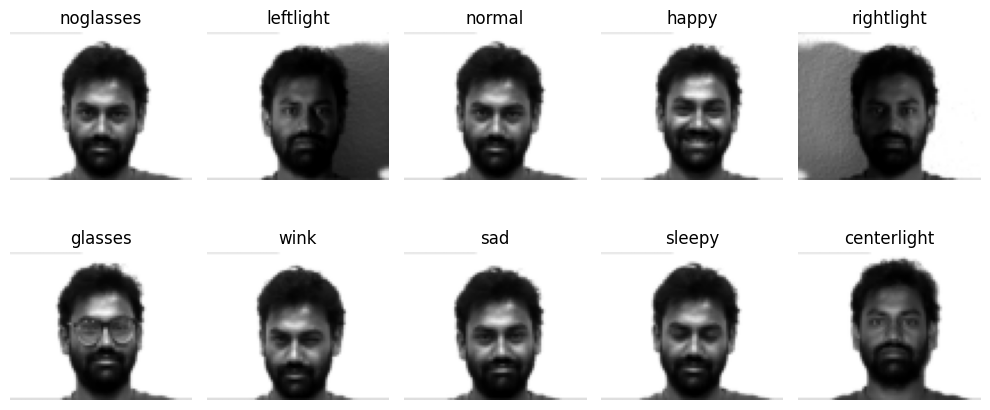

In [58]:
# Hiển thị một số ảnh train
selected_person = random.choice(person_folders)
print(f"Hiển thị ảnh của người: {selected_person}")
display_images(base_path=train_path, person_path=selected_person, img_size=(65, 80), num_images_to_display=10)

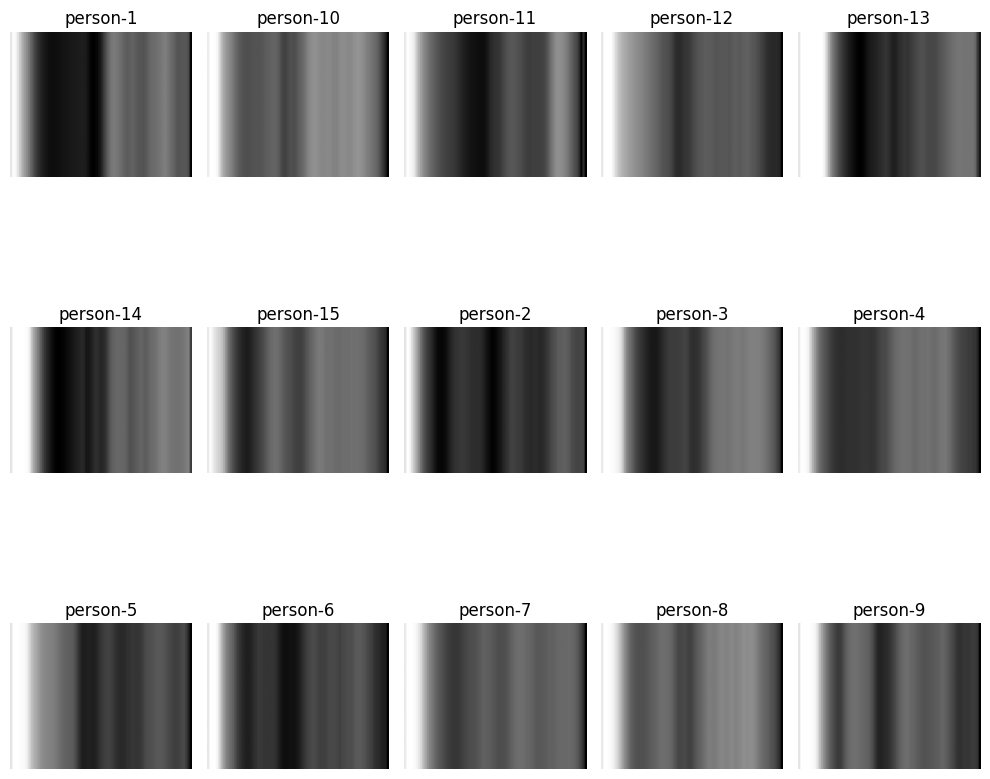

In [59]:
# Tính và hiển thị mean face cho từng người
data = {}
for label in np.unique(y_train):
    person_name = person_folders[label]
    data[person_name] = train_images[y_train == label]

mean_faces = [
    np.mean(images, axis=0) for person, images in data.items()
]

plt.figure(figsize=[10, 10])  # width, height in inches
for ith, mean_face in enumerate(mean_faces):
    mean_face = mean_face.reshape(64, 80)

    # display each image in a subplot
    plt.subplot(3, 5, ith + 1)  # 3 rows, 5 columns
    plt.imshow(mean_face, cmap='gray')
    plt.axis('off')  # hide axes
    plt.title(person_folders[ith])

plt.tight_layout()
plt.show()

In [60]:
# Chuẩn hóa từng ảnh
train_images_standardized = standardize_per_image(train_images)
print(f"Train standardized: min={train_images_standardized.min():.2f}, max={train_images_standardized.max():.2f}")

Train standardized: min=-3.03, max=3.99


In [61]:
# Kiểm tra inf và NaN trước khi áp dụng PCA
if np.any(np.isinf(train_images_reshaped)) or np.any(np.isnan(train_images_reshaped)):
    print("Dữ liệu chứa inf hoặc NaN.")
    train_images_reshaped = np.nan_to_num(train_images_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

In [62]:
# Reshape để áp dụng PCA
train_images_reshaped = train_images_standardized.reshape(len(train_images), -1)

In [63]:
# Áp dụng PCA với 20 chiều
pca_model = Principle_Component_Analysis(d_principle=20)

In [64]:
train_images_reshaped = train_images_standardized.reshape(len(train_images), -1)
X_train_pca = pca_model.fit_transform(train_images_reshaped)
print(f"Kích thước dữ liệu train sau PCA: {X_train_pca.shape}")

Kích thước dữ liệu train sau PCA: (150, 20)


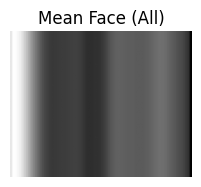

In [65]:
# Hiển thị mean face toàn bộ tập train
mean_face = pca_model.mean_.reshape(64, 80)
display_images(images=[mean_face], titles=["Mean Face (All)"], num_images_to_display=1)

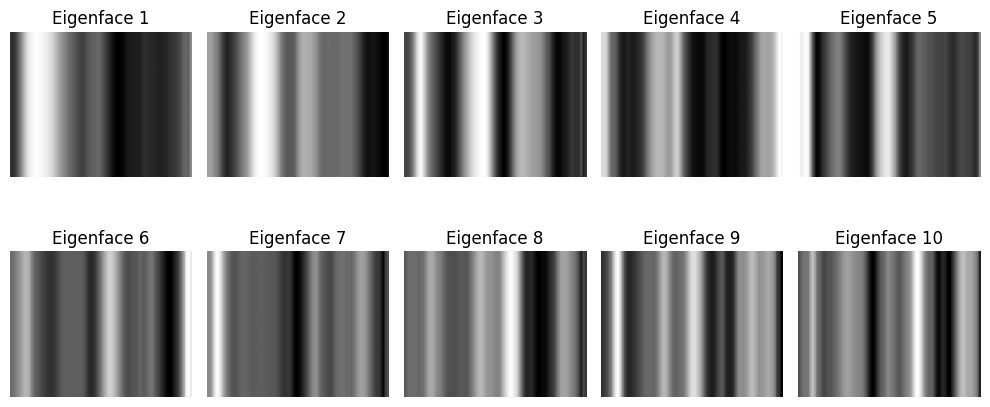

In [66]:
# Hiển thị eigenfaces
eigenfaces = pca_model._W
eigenfaces_images = eigenfaces.reshape(20, 64, 80)
eigenfaces_titles = [f"Eigenface {i+1}" for i in range(20)]
display_images(images=eigenfaces_images[:10], titles=eigenfaces_titles[:10], num_images_to_display=10)

In [67]:
# In tỷ lệ phương sai giải thích
explained_variance_ratio = pca_model.explained_variance_ratio_
print(f"Tỷ lệ phương sai giải thích của 20 thành phần chính: {explained_variance_ratio}")
print(f"Tổng tỷ lệ phương sai giải thích: {np.sum(explained_variance_ratio):.2f}")

Tỷ lệ phương sai giải thích của 20 thành phần chính: [0.32790768 0.24205123 0.10484806 0.08401794 0.05592519 0.04563431
 0.02862432 0.02350564 0.01726696 0.00984643 0.00911965 0.00744579
 0.00559169 0.00513874 0.0047187  0.00429397 0.00349198 0.00307806
 0.00237177 0.00190279]
Tổng tỷ lệ phương sai giải thích: 0.99


**Assignment 3 (2 scores):**
*   Assign persons to the face images in testing data.
*   Evaluate the accuracy of this face recognition system.

In [70]:
# Load ảnh từ tập test
print("\nLoad tập test:")
test_images, y_test, test_filenames, _ = load_all_images(test_path, img_size=(64, 80))
print(f"Số lượng ảnh test: {len(test_images)}")


Load tập test:
Số lượng ảnh mỗi người:
Nhãn 0 (test): 15 ảnh
Số lượng ảnh test: 15


Hiển thị ảnh test của người: test


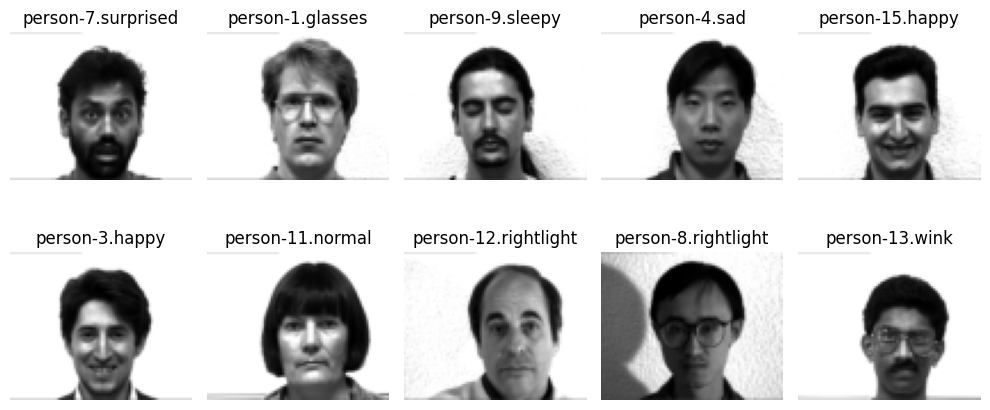

In [71]:
# Hiển thị một số ảnh test
test_person_folders = [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))]
if test_person_folders:
    selected_test_person = random.choice(test_person_folders)
    print(f"Hiển thị ảnh test của người: {selected_test_person}")
    display_images(base_path=test_path, person_path=selected_test_person, img_size=(65, 80), num_images_to_display=10)
else:
    print("Không tìm thấy thư mục nào trong test_path.")

In [72]:
# Chuẩn hóa từng ảnh trong tập test
test_images_standardized = standardize_per_image(test_images)
print(f"Test standardized: min={test_images_standardized.min():.2f}, max={test_images_standardized.max():.2f}")

Test standardized: min=-2.71, max=3.22


In [73]:
# Reshape và kiểm tra inf/NaN
test_images_reshaped = test_images_standardized.reshape(len(test_images), -1)

In [74]:
# Kiểm tra inf và NaN
if np.any(np.isinf(test_images_standardized)) or np.any(np.isnan(test_images_standardized)):
    print("Dữ liệu test chứa inf hoặc NaN.")
    test_images_standardized = np.nan_to_num(test_images_standardized, nan=0.0, posinf=0.0, neginf=0.0)

In [75]:
# Transform tập test
X_test_pca = pca_model.transform(test_images_reshaped)
print(f"Kích thước dữ liệu test sau PCA: {X_test_pca.shape}")

Kích thước dữ liệu test sau PCA: (15, 20)


In [76]:
# Phân loại ảnh test với k-NN
k = 3  # Số neighbor
y_pred = []

for x in X_test_pca:
    distances = np.sqrt(np.sum((X_train_pca - x) ** 2, axis=1))
    nearest_indices = np.argsort(distances)[:k]  # Lấy k chỉ số gần nhất
    nearest_labels = y_train[nearest_indices]
    most_common_label = Counter(nearest_labels).most_common(1)[0][0]
    y_pred.append(most_common_label)

In [77]:
# Tính độ chính xác
accuracy = np.mean(np.array(y_pred) == y_test)
print(f"Accuracy với k-NN (k={k}): {accuracy*100:.2f}%")

Accuracy với k-NN (k=3): 13.33%


In [78]:
# In một số dự đoán để kiểm tra
print("\nMột số dự đoán mẫu:")
for i in range(min(5, len(y_pred))):
    print(f"Ảnh test {i}: Dự đoán = {y_pred[i]}, Thực tế = {y_test[i]}")


Một số dự đoán mẫu:
Ảnh test 0: Dự đoán = 12, Thực tế = 0
Ảnh test 1: Dự đoán = 0, Thực tế = 0
Ảnh test 2: Dự đoán = 14, Thực tế = 0
Ảnh test 3: Dự đoán = 9, Thực tế = 0
Ảnh test 4: Dự đoán = 6, Thực tế = 0
